In [1]:
""" House Pricing Regression Problem"""
# 1 Problem Definition

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

In [3]:
# 2 Load packages & Load the data
# 2.1 Load packages
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

# For grid search
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

# custom functions
from showDataCharactereistics import list_nans_counts
from showDataCharactereistics import list_nans_only, get_large_nans, replace_large_nans, view_non_numeric_feature_values
from showDataCharactereistics import get_column_fix_list

In [4]:
#2.2 Load training data

#Determine file encoding
training_file_path = "train.csv"

import chardet
with open(training_file_path, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
theEncoding = result['encoding']

training_data = pd.read_csv(training_file_path, encoding=theEncoding, keep_default_na=False)

# Load test or predict data
predict_file_path = "test.csv"

predict_data = pd.read_csv(predict_file_path, encoding=theEncoding, keep_default_na=False)


In [5]:
#3. Exploratory Data Analysis
# 3.1 Explore feature data

training_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500


In [6]:
# Id adds no value to the modeling process, so it is dropped
training_data = training_data[training_data.columns.difference(["Id"], sort=False)]

In [7]:
training_data.shape

(1460, 80)

In [8]:
training_data.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,1057.429452,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,438.705324,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,991.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,1298.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


<Axes: xlabel='SalePrice', ylabel='Count'>

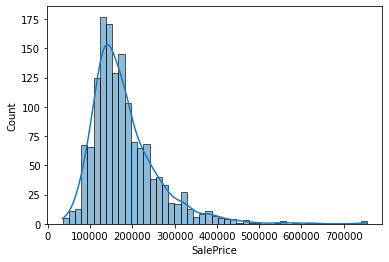

In [9]:
sns.histplot(data = training_data, x = "SalePrice", kde = True)

In [10]:
# Explore feature data types
# set_option('display.max_rows', 500)
for (i,j) in zip(training_data.columns, training_data.dtypes):
    print(i, " ", j)

MSSubClass   int64
MSZoning   object
LotFrontage   object
LotArea   int64
Street   object
Alley   object
LotShape   object
LandContour   object
Utilities   object
LotConfig   object
LandSlope   object
Neighborhood   object
Condition1   object
Condition2   object
BldgType   object
HouseStyle   object
OverallQual   int64
OverallCond   int64
YearBuilt   int64
YearRemodAdd   int64
RoofStyle   object
RoofMatl   object
Exterior1st   object
Exterior2nd   object
MasVnrType   object
MasVnrArea   object
ExterQual   object
ExterCond   object
Foundation   object
BsmtQual   object
BsmtCond   object
BsmtExposure   object
BsmtFinType1   object
BsmtFinSF1   int64
BsmtFinType2   object
BsmtFinSF2   int64
BsmtUnfSF   int64
TotalBsmtSF   int64
Heating   object
HeatingQC   object
CentralAir   object
Electrical   object
1stFlrSF   int64
2ndFlrSF   int64
LowQualFinSF   int64
GrLivArea   int64
BsmtFullBath   int64
BsmtHalfBath   int64
FullBath   int64
HalfBath   int64
BedroomAbvGr   int64
KitchenAbvGr   int6

In [11]:
# 4. Data preparation
# 4.1. Data cleaning
# View & identify if some columns have a large number of NA/NaN values

list_nans_counts(training_data)

Col#	Column				Number		Strings		Other		Blanks		NaN

0	MSSubClass          		1460		0		0		0		0
1	MSZoning            		0		1460		0		0		0
2	LotFrontage         		0		1201		0		0		259
3	LotArea             		1460		0		0		0		0
4	Street              		0		1460		0		0		0
5	Alley               		0		91		0		0		1369
6	LotShape            		0		1460		0		0		0
7	LandContour         		0		1460		0		0		0
8	Utilities           		0		1460		0		0		0
9	LotConfig           		0		1460		0		0		0
10	LandSlope           		0		1460		0		0		0
11	Neighborhood        		0		1460		0		0		0
12	Condition1          		0		1460		0		0		0
13	Condition2          		0		1460		0		0		0
14	BldgType            		0		1460		0		0		0
15	HouseStyle          		0		1460		0		0		0
16	OverallQual         		1460		0		0		0		0
17	OverallCond         		1460		0		0		0		0
18	YearBuilt           		1460		0		0		0		0
19	YearRemodAdd        		1460		0		0		0		0
20	RoofStyle           		0		1460		0		0		0
21	RoofMatl            		0		1460		0		0		0
22	Exterior1st         		0		146

In [12]:
# View  the columns that have a large number of NA/NaN values

list_nans_only()

Sr#	Col#	Column				Number		Strings		Other		Blanks		NaN

1	2	LotFrontage         		0		1201		0		0		259
2	5	Alley               		0		91		0		0		1369
3	24	MasVnrType          		0		1452		0		0		8
4	25	MasVnrArea          		0		1452		0		0		8
5	29	BsmtQual            		0		1423		0		0		37
6	30	BsmtCond            		0		1423		0		0		37
7	31	BsmtExposure        		0		1422		0		0		38
8	32	BsmtFinType1        		0		1423		0		0		37
9	34	BsmtFinType2        		0		1422		0		0		38
10	41	Electrical          		0		1459		0		0		1
11	56	FireplaceQu         		0		770		0		0		690
12	57	GarageType          		0		1379		0		0		81
13	58	GarageYrBlt         		0		1379		0		0		81
14	59	GarageFinish        		0		1379		0		0		81
15	62	GarageQual          		0		1379		0		0		81
16	63	GarageCond          		0		1379		0		0		81
17	71	PoolQC              		0		7		0		0		1453
18	72	Fence               		0		281		0		0		1179
19	73	MiscFeature         		0		54		0		0		1406


In [13]:
drop_columns, fix_columns = get_large_nans(689)

print(drop_columns)

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [14]:
# GarageYrBlt has 81 values missing. It does not make a lot of sense to impute the year a garage was built
# So I in remove it from fix_columns. 
# Placing it in drop_columns would imply deleting the entire column which is undesirable
fix_columns.remove('GarageYrBlt')

# Then drop the records with GarageYrBlt = NaN
recordsNaN = training_data[(training_data['GarageYrBlt'] == 'NA') ].index
training_data.drop(recordsNaN, inplace=True)
training_data['GarageYrBlt']=pd.to_numeric(training_data['GarageYrBlt'], errors='coerce')

In [15]:
print(fix_columns)

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


In [16]:
# Exclude columns with NaN/NA from training data frame
column_trimmed_training_data = training_data[training_data.columns.difference(drop_columns, sort=False)]
column_trimmed_training_data.shape

(1379, 75)

In [17]:
# View columns with an acceptable number of NaNs 
print(fix_columns)

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


In [18]:
column_trimmed_training_data[fix_columns].head(100)

,LotFrontage,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageFinish,GarageQual,GarageCond
0,65,BrkFace,196,Gd,TA,No,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA
1,80,None,0,Gd,TA,Gd,ALQ,Unf,SBrkr,Attchd,RFn,TA,TA
2,68,BrkFace,162,Gd,TA,Mn,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA
3,60,None,0,TA,Gd,No,ALQ,Unf,SBrkr,Detchd,Unf,TA,TA
4,84,BrkFace,350,Gd,TA,Av,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,77,BrkFace,336,Gd,TA,No,Unf,Unf,SBrkr,Attchd,Fin,TA,TA
102,64,None,0,NA,NA,NA,NA,NA,SBrkr,Attchd,Unf,TA,TA
103,94,None,0,Gd,TA,No,Unf,Unf,SBrkr,Attchd,RFn,TA,TA
104,NA,BrkFace,600,TA,TA,No,LwQ,Unf,FuseF,Detchd,Unf,TA,TA


In [19]:
# Determine which columns are numeric from the ones with a low number of NaNs 
# replace the NANs with column mean the rest with blanks
imputed_training_data = replace_large_nans(column_trimmed_training_data, fix_columns)

#Confirm that the NaNs and blanks are gone
list_nans_counts(imputed_training_data)

Col#	Column				Number		Strings		Other		Blanks		NaN

0	MSSubClass          		1379		0		0		0		0
1	MSZoning            		0		1379		0		0		0
2	LotFrontage         		1379		0		0		0		0
3	LotArea             		1379		0		0		0		0
4	Street              		0		1379		0		0		0
5	LotShape            		0		1379		0		0		0
6	LandContour         		0		1379		0		0		0
7	Utilities           		0		1379		0		0		0
8	LotConfig           		0		1379		0		0		0
9	LandSlope           		0		1379		0		0		0
10	Neighborhood        		0		1379		0		0		0
11	Condition1          		0		1379		0		0		0
12	Condition2          		0		1379		0		0		0
13	BldgType            		0		1379		0		0		0
14	HouseStyle          		0		1379		0		0		0
15	OverallQual         		1379		0		0		0		0
16	OverallCond         		1379		0		0		0		0
17	YearBuilt           		1379		0		0		0		0
18	YearRemodAdd        		1379		0		0		0		0
19	RoofStyle           		0		1379		0		0		0
20	RoofMatl            		0		1379		0		0		0
21	Exterior1st         		0		1379		0		0		0
22	Exterior2nd         		0		1379		

In [20]:
# Explore non numeric features that could be included in the analysis
# Those attributes with one values throughout are dropped from the list
metricFeatures, nonMetricFeatures, nonMetricDF = view_non_numeric_feature_values(imputed_training_data)

pd.set_option('display.max_colwidth', None)

nonMetricDF.head(nonMetricDF.shape[0])

,ID,Attribute,Values,Value List
0,1,MSZoning,5,"{RL, FV, RH, RM, C (all)}"
1,4,Street,2,"{Grvl, Pave}"
2,5,LotShape,4,"{IR1, IR2, IR3, Reg}"
3,6,LandContour,4,"{Lvl, Bnk, Low, HLS}"
4,7,Utilities,2,"{AllPub, NoSeWa}"
5,8,LotConfig,5,"{CulDSac, Inside, FR2, FR3, Corner}"
6,9,LandSlope,3,"{Gtl, Mod, Sev}"
7,10,Neighborhood,25,"{StoneBr, Gilbert, NPkVill, NAmes, Mitchel, BrDale, SawyerW, MeadowV, Blueste, Timber, ClearCr, Crawfor, Somerst, NWAmes, Sawyer, SWISU, Blmngtn, Edwards, BrkSide, NoRidge, Veenker, CollgCr, NridgHt, IDOTRR, OldTown}"
8,11,Condition1,9,"{PosN, RRAe, PosA, RRNe, Norm, RRAn, Artery, RRNn, Feedr}"
9,12,Condition2,8,"{PosN, RRAe, PosA, Norm, RRAn, Artery, RRNn, Feedr}"


In [21]:
# Features that have a single value will not contribute to the analysis and were dropped
# Other than numeric fields, we now have 27 non numeric fields to consider

len(nonMetricDF["Attribute"])

27

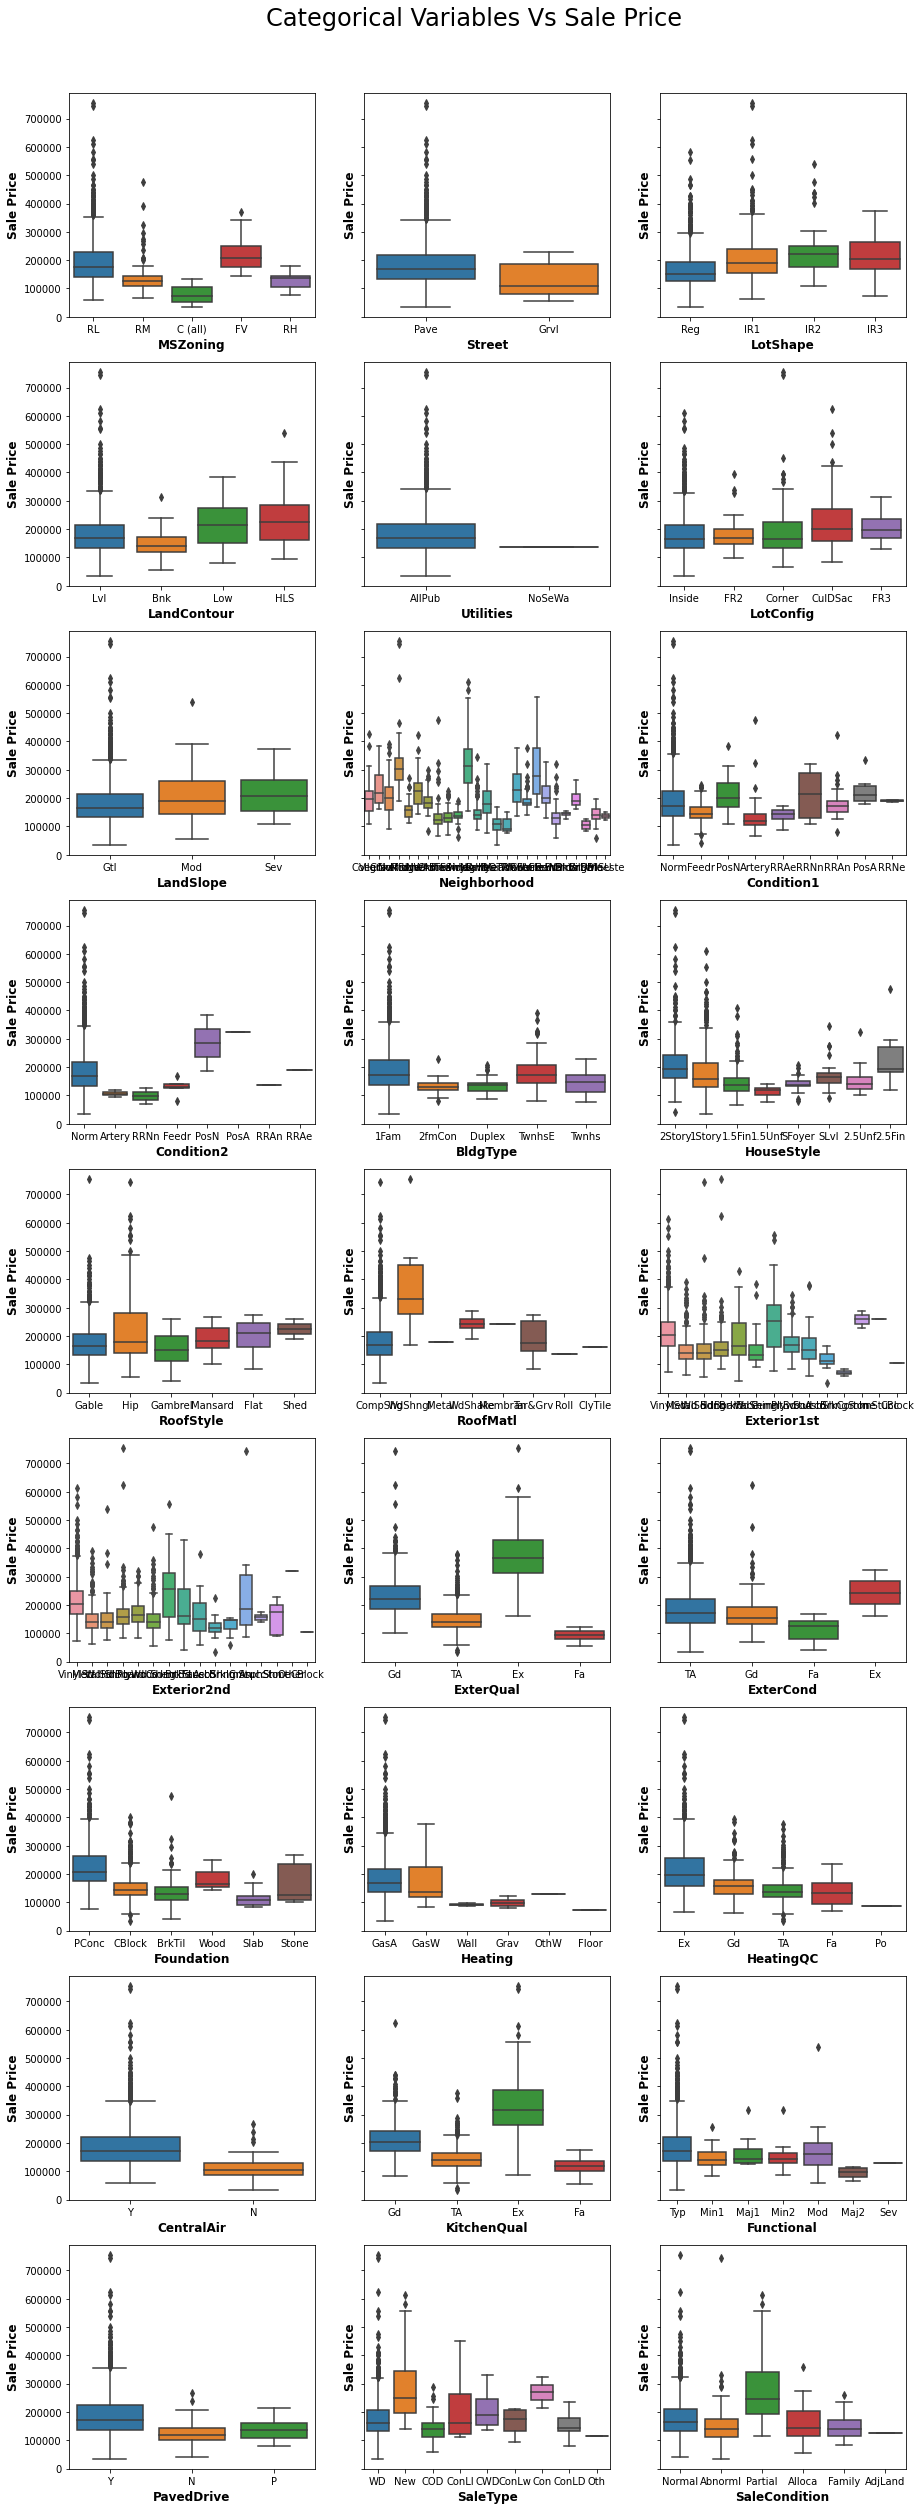

In [22]:
# Plot the remaining nonmetric attributes against sale price to get a feel on their effects on sale price.
# Assign Sale price to y, the dependent variable

Y = imputed_training_data.SalePrice

# Initialise the subplot function. Because we have 27 independent attributes remaining, we us a 9 x 3 matrix
figure, axis = plt.subplots(9, 3, sharey=True, figsize=(15,40))

#figure.tight_layout()
figure.subplots_adjust(top=0.95)

# Set title for plot
figure.suptitle("Categorical Variables Vs Sale Price", size=24)

for ax, variate in zip(axis.flatten(), (nonMetricDF["Attribute"])):
    # Assign variate to x, the independent variable
    X = imputed_training_data[variate]
                
    sns.boxplot(data=imputed_training_data, x=X, y=Y, ax=ax)
    #ax.set_xlabel(variate, size = 12 )
    ax.set_xlabel(variate, fontdict={'size': 12, 'weight': 'bold'})
    ax.set_ylabel("Sale Price", fontdict={'size': 12, 'weight': 'bold'})

plt.show()

In [23]:
# From the box plots it is clear that for most of the categorical variables, there is at least one value that 
# nearly spreads across all price range such that the categorical values do seem to have an effect on house pricing.
# For this reason, out of all the categorical variables I proceed with Neigborhood, ExterQual, KitchenQual only 
# together with the numeric variables.

In [24]:
# Drop all categorical columns from current training data frame - imputed_training_data

# Drop all remaining non metric features in the list
training_metric = imputed_training_data.drop(nonMetricFeatures, axis=1)

training_features_metric = list(training_metric.columns)
X_metric = training_metric[training_features_metric]
X_metric = X_metric[X_metric.columns.difference(["SalePrice"], sort=False)]

In [25]:
# First remove Neigborhood, ExterQual, KitchenQual from list
nonMetricFeatures.remove('Neighborhood')
nonMetricFeatures.remove('ExterQual')
nonMetricFeatures.remove('KitchenQual')

# Drop all remaining non metric features in the list except Neighborhood, ExterQual, KitchenQual
training_with_Qual = imputed_training_data.drop(nonMetricFeatures, axis=1)

# Get dummy columns for Neighborhood, ExterQual, KitchenQual 
training_with_Qual = pd.get_dummies(training_with_Qual, columns = ['ExterQual','KitchenQual', 'Neighborhood'])

training_features_Qual = list(training_with_Qual.columns)
X_Qual = training_with_Qual[training_features_Qual]
X_Qual = X_Qual[X_Qual.columns.difference(["SalePrice"], sort=False)]

In [26]:
X_metric.shape

(1379, 36)

In [27]:
X_Qual.shape

(1379, 69)

In [28]:
# 4. Feature Selection
#A F-test captures only linear dependency. 
#On the other hand, mutual information can capture any kind of dependency between variables

Y = training_metric.SalePrice

In [29]:
# Get best features of metric variable using f_regression
k_value = 16
bestfeatures = SelectKBest(f_regression, k = k_value)

fit = bestfeatures.fit(X_metric, Y)
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(X_metric.columns)

featureScores = pd.concat([columns, scores], axis=1)
featureScores = pd.DataFrame(featureScores)
featureScores.rename(columns={featureScores.columns[0]:"Attribute", featureScores.columns[1]:"Score"}, inplace=True)
featureScores.columns.values[0] = "Attribute"
featureScores.columns.values[1] = "Score"

print(featureScores.nlargest(16, "Score")) #print 16 best features

       Attribute        Score
3    OverallQual  2244.088940
15     GrLivArea  1385.329767
25    GarageCars   940.754776
26    GarageArea   809.259075
11   TotalBsmtSF   789.160142
12      1stFlrSF   754.407299
18      FullBath   617.924283
22  TotRmsAbvGrd   561.826881
5      YearBuilt   477.899151
6   YearRemodAdd   472.473016
24   GarageYrBlt   426.648985
7     MasVnrArea   381.609892
23    Fireplaces   347.463958
8     BsmtFinSF1   226.115205
28   OpenPorchSF   171.780002
1    LotFrontage   167.402147


In [30]:
# Get best features with Neigborhood, ExterQual & KitchenQual
bestfeatures_Qual = SelectKBest(f_regression, k = k_value)

fit_Qual = bestfeatures_Qual.fit(X_Qual, Y)
scores_Qual = pd.DataFrame(fit_Qual.scores_)
columns_Qual = pd.DataFrame(X_Qual.columns)
featureScores_Qual = pd.concat([columns_Qual, scores_Qual],axis=1)
featureScores_Qual = pd.DataFrame(featureScores_Qual)
featureScores_Qual.rename(columns={featureScores_Qual.columns[0]:"Attribute", featureScores_Qual.columns[1]:"Score"}, inplace=True)
featureScores_Qual.columns.values[0] = "Attribute"
featureScores_Qual.columns.values[1] = "Score"

print(featureScores_Qual.nlargest(16,'Score')) #print 16 best features

         Attribute        Score
3      OverallQual  2244.088940
15       GrLivArea  1385.329767
25      GarageCars   940.754776
26      GarageArea   809.259075
11     TotalBsmtSF   789.160142
12        1stFlrSF   754.407299
39    ExterQual_TA   737.668392
18        FullBath   617.924283
22    TotRmsAbvGrd   561.826881
43  KitchenQual_TA   528.694520
40  KitchenQual_Ex   494.384200
5        YearBuilt   477.899151
6     YearRemodAdd   472.473016
24     GarageYrBlt   426.648985
7       MasVnrArea   381.609892
36    ExterQual_Ex   361.052506


In [31]:
# Collect Attributes selected using f_regression
f_reg_20m = pd.DataFrame(featureScores.nlargest(20, "Score"))

print(list(f_reg_20m['Attribute']))

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'OpenPorchSF', 'LotFrontage', '2ndFlrSF', 'WoodDeckSF', 'HalfBath', 'LotArea']


In [32]:
# Collect Attributes selected using f_regression (Neigborhood, ExterQual,KitchenQual)
f_reg_20q = pd.DataFrame(featureScores_Qual.nlargest(20, "Score"))

print(list(f_reg_20q['Attribute']))

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'ExterQual_TA', 'FullBath', 'TotRmsAbvGrd', 'KitchenQual_TA', 'KitchenQual_Ex', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'ExterQual_Ex', 'Fireplaces', 'ExterQual_Gd', 'Neighborhood_NridgHt', 'BsmtFinSF1']


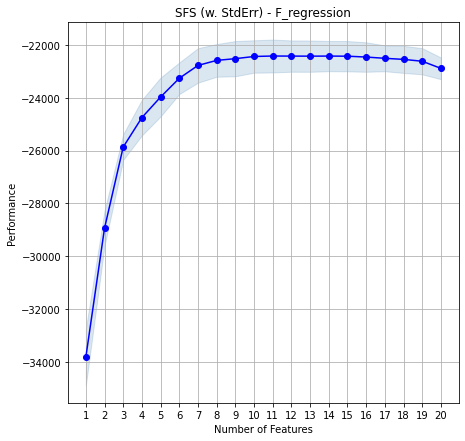

SFS - F_regression (k=16): 

Selected features: ['0 -> OverallQual', '1 -> GrLivArea', '2 -> GarageCars', '3 -> GarageArea', '4 -> TotalBsmtSF', '5 -> 1stFlrSF', '6 -> FullBath', '7 -> TotRmsAbvGrd', '8 -> YearBuilt', '9 -> YearRemodAdd', '10 -> GarageYrBlt', '11 -> MasVnrArea', '12 -> Fireplaces', '13 -> BsmtFinSF1', '14 -> OpenPorchSF', '15 -> LotFrontage', '16 -> 2ndFlrSF', '17 -> WoodDeckSF', '18 -> HalfBath', '19 -> LotArea']

Prediction score: -22894.355859524094


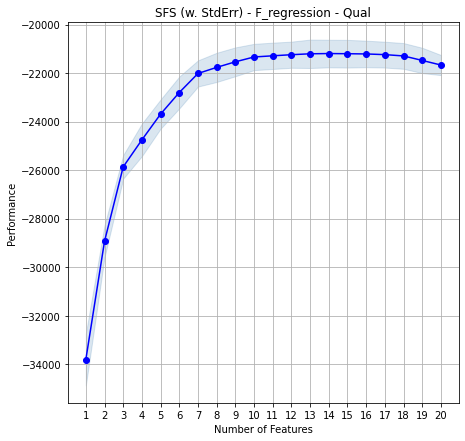

SFS - F_regression - Qual (k=16): 

Selected features: ['0 -> OverallQual', '1 -> GrLivArea', '2 -> GarageCars', '3 -> GarageArea', '4 -> TotalBsmtSF', '5 -> 1stFlrSF', '6 -> ExterQual_TA', '7 -> FullBath', '8 -> TotRmsAbvGrd', '9 -> KitchenQual_TA', '10 -> KitchenQual_Ex', '11 -> YearBuilt', '12 -> YearRemodAdd', '13 -> GarageYrBlt', '14 -> MasVnrArea', '15 -> ExterQual_Ex', '16 -> Fireplaces', '17 -> ExterQual_Gd', '18 -> Neighborhood_NridgHt', '19 -> BsmtFinSF1']

Prediction score: -21670.835290912823


In [33]:
# Data Transformation

names_r = list(f_reg_20m['Attribute'])
names_rq = list(f_reg_20q['Attribute'])
names = list([names_r, names_rq])
reg_names = list(["F_regression", "F_regression - Qual"])

labels = training_metric['SalePrice']

lr = LinearRegression()

for ax, nms in zip(axis.flatten(), range(len(names))):
   
    X = training_with_Qual[names[nms]]
    scaler = StandardScaler().fit(X)
    StandardisedX = pd.DataFrame(scaler.fit_transform(X))
    
    X, y = StandardisedX, labels

    sfs = SFS(lr, k_features=StandardisedX.shape[1], forward=True, 
                              floating=False,                     
                              scoring='neg_mean_absolute_error',
                              cv=5)

    sfs = sfs.fit(X, y)
    
    figure = plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(7,7))    
                    
    titleString = "SFS (w. StdErr) - " + reg_names[nms]
    plt.title(titleString)
    plt.grid()    
    plt.show()
    
    print("SFS - "+ reg_names[nms] +" (k="+ str(k_value) +"): ")
    
    feat_names=[]
    for i in range(len(sfs.k_feature_idx_)):
        ft_id = sfs.k_feature_idx_[i]
        feat_names.append(str(ft_id) + " -> " + names[nms][i])
    
    print("\nSelected features:", feat_names)
    
    print("\nPrediction score:", sfs.k_score_)

In [34]:
# With Neighborhood, ExterQual and KitchenQual included, we get better scores
# So I proceed with the set of features that includes them.

In [35]:
# Sequential Forward Floating Selection (SFFS)
# SFFS is considered an extension to the simpler SFS algorithms. 
# The floating algorithm has an additional exclusion or inclusion step to remove features once they were included 
# (or excluded) so that a larger number of feature subset combinations can be sampled. 
# It is important to emphasize that this step is conditional and only occurs if the resulting feature subset is assessed 
# as "better" by the criterion function after the removal (or addition) of a particular feature.

Best combination (ACC: -17731.210): (0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 16, 19)



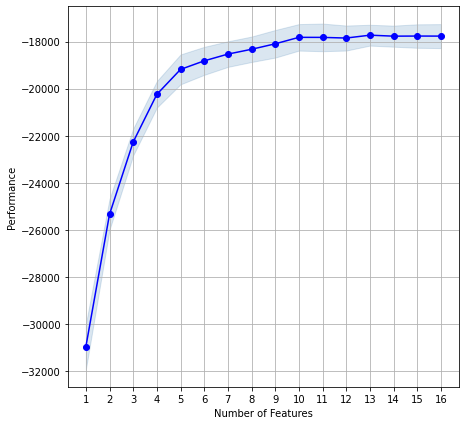

In [36]:
# 5. Evaluate Models
# Evaluate features to determine the best Set

X = training_with_Qual[names_rq[0:20]]
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))

X, y = StandardisedX, labels

# Random forest estimator gives more or less the same result as xgboost but is much slower
#rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=1)

xgb = XGBRegressor(n_estimators=100, eta= 0.1)

sfs_range = SFS(estimator=xgb, 
                k_features=(2, 16), # TRY FROM 2 TO 16 FEATURES
                forward=True,
                floating=True,
                scoring='neg_mean_absolute_error',
                cv=5)             

sfs_range = sfs_range.fit (X,y)

print('Best combination (ACC: %.3f): %s\n' % ( sfs_range.k_score_, sfs_range.k_feature_idx_))

plot_sfs(sfs_range.get_metric_dict(), kind='std_err', figsize=(7,7))
plt.grid()

# Collect the best features in one list
bestSet = []
bestSetNames = dict()
j=0
for i in sfs_range.k_feature_idx_:
    bestSet.append(names_rq[i])
    bestSetNames[j] = names_rq[i]
    j += 1

In [37]:
# The following following combination of features are likely to provide the best results
print(bestSet)

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'ExterQual_TA', 'FullBath', 'TotRmsAbvGrd', 'KitchenQual_Ex', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'BsmtFinSF1']


In [38]:
bestSet_X = training_with_Qual[bestSet]

bestSet_X.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,ExterQual_TA,FullBath,TotRmsAbvGrd,KitchenQual_Ex,YearBuilt,YearRemodAdd,Fireplaces,BsmtFinSF1
0,7,1710,2,856,856,0,2,8,0,2003,2003,0,706
1,6,1262,2,1262,1262,1,2,6,0,1976,1976,1,978
2,7,1786,2,920,920,0,2,6,0,2001,2002,1,486
3,7,1717,3,756,961,1,1,7,0,1915,1970,1,216
4,8,2198,3,1145,1145,0,2,9,0,2000,2000,1,655


<Axes: title={'center': 'Correlation Matrix'}>

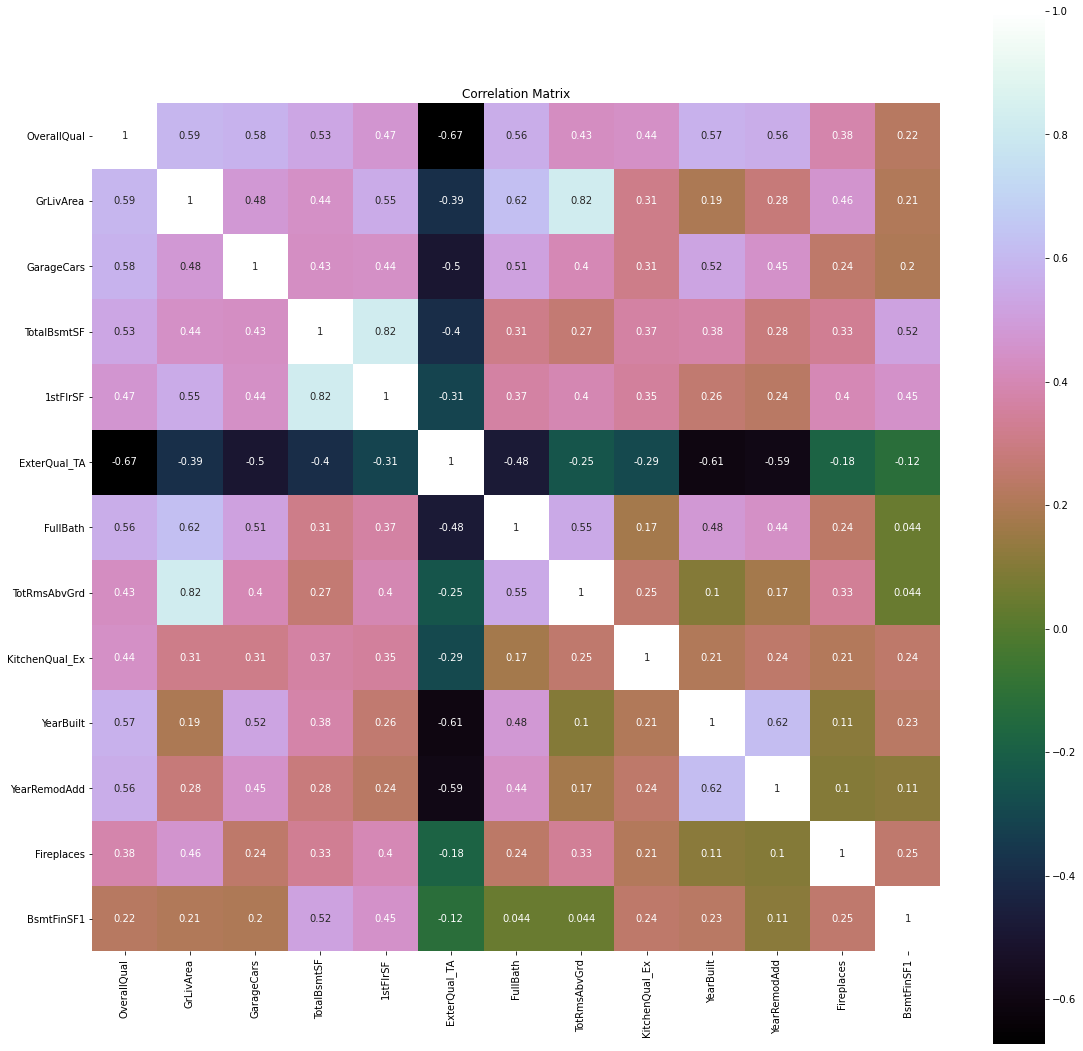

In [39]:
# Data visualization
# Multivariate data hence a correlation matrix plot may be necessary

correlation = bestSet_X.corr()
plt.figure(figsize=(19,19))
plt.title('Correlation Matrix')

sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [40]:
"""
ExterQual_TA mostly has a negative correlation with the rest of the independent variables. e.g.
ExterQual_TA has a -0.67 correlation with OverallQual.YearBuilt is next with -0.61.
Interestingly, ExterQual_TA has no the positive correlation. This highest positive correlation on the entire map is 0.82, 
and this occurrs between a number of sets of variables.
Otherwise there is no perfect multicolinearity in the predictors, so current features remain.
"""

'\nExterQual_TA mostly has a negative correlation with the rest of the independent variables. e.g.\nExterQual_TA has a -0.67 correlation with OverallQual.YearBuilt is next with -0.61.\nInterestingly, ExterQual_TA has no the positive correlation. This highest positive correlation on the entire map is 0.82, \nand this occurrs between a number of sets of variables.\nOtherwise there is no perfect multicolinearity in the predictors, so current features remain.\n'

In [41]:
# Multivariate hence a scatterplot matrix may be necessary, however, the variables are still too many to make sense of
# from pandas.plotting import scatter_matrix

# scatter_matrix(bestSet_X, figsize=(19,19))

In [42]:
# 5.1 Training & Test Split
from sklearn.model_selection import train_test_split

X = training_with_Qual[bestSet]

scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))

X, y = StandardisedX, labels

validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [43]:
#5.2. Identify evaluation metrics
# I will compare the Mean Absolute Error for Linear Regression, Polynomial Regression & Random Forests

model_List = []
mae_List = []
mape_List = []
rmse_List = []

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

Y_linear_pred = linear_model.predict(X_validation)

linear_mae = mean_absolute_error(Y_validation, Y_linear_pred)
linear_mape = mean_absolute_percentage_error(Y_validation, Y_linear_pred)
linear_rmse = np.sqrt(mean_squared_log_error(Y_validation, Y_linear_pred))

model_List.append("Linear")
mae_List.append(linear_mae)
mape_List.append(linear_mape)
rmse_List.append(linear_rmse)

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)
x_poly_val = polynomial_features.fit_transform(X_validation)

poly_model = LinearRegression()
poly_model.fit(x_poly, Y_train)

Y_poly_pred = poly_model.predict(x_poly_val)
poly_mae = mean_absolute_error(Y_validation, Y_poly_pred)
poly_mape = mean_absolute_percentage_error(Y_validation, Y_poly_pred)
poly_rmse = np.sqrt(mean_squared_log_error(Y_validation, Y_poly_pred))

model_List.append("Polynomial")
mae_List.append(poly_mae)
mape_List.append(poly_mape)
rmse_List.append(poly_rmse)

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train, Y_train)
    
Y_forest_pred = forest_model.predict(X_validation)
forest_mae = mean_absolute_error(Y_validation, Y_forest_pred)
forest_mape = mean_absolute_percentage_error(Y_validation, Y_forest_pred)
forest_rmse = np.sqrt(mean_squared_log_error(Y_validation, Y_forest_pred))

model_List.append("Random Forest")
mae_List.append(forest_mae)
mape_List.append(forest_mape)
rmse_List.append(forest_rmse)

xgb_model = XGBRegressor()
xgb_model.fit(X_train, Y_train)
    
Y_xgb_pred = xgb_model.predict(X_validation)
xgb_mae = mean_absolute_error(Y_validation, Y_xgb_pred)
xgb_mape = mean_absolute_percentage_error(Y_validation, Y_xgb_pred)
xgb_rmse = np.sqrt(mean_squared_log_error(Y_validation, Y_xgb_pred))

model_List.append("XGBoost")
mae_List.append(xgb_mae)
mape_List.append(xgb_mape)
rmse_List.append(xgb_rmse)

performance_df = pd.DataFrame(list(zip(model_List, mae_List, mape_List, rmse_List)), 
                              columns =['Model', 'MAE', 'MAPE', 'RMSE'])
performance_df

,Model,MAE,MAPE,RMSE
0,Linear,23354.517140,0.123252,0.164038
1,Polynomial,20092.333333,0.109254,0.156757
2,Random Forest,20405.883519,0.112318,0.156711
3,XGBoost,19594.359262,0.108615,0.153592


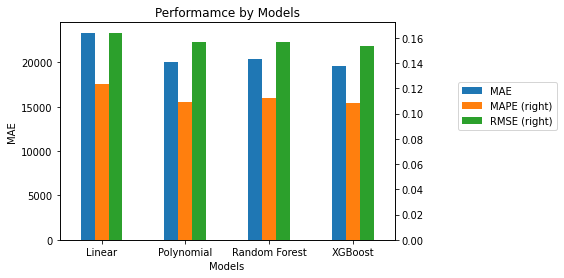

In [44]:
ax = performance_df.plot( kind= 'bar', secondary_y=['MAPE', 'RMSE'], title='Performamce by Models',
                        xlabel = "Models",
                        ylabel = "MAE",
                        rot= 0 )

ax.set_xticklabels(performance_df.Model)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.5, 0.75))

plt.show()

In [45]:
# XGBoost has the best performance, so I will proceed to create the model using the 'bestSet' features.

In [46]:
# Explore target data
predict_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1,1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal


In [47]:
# Get dummy columns for Neighborhood, ExterQual, KitchenQual 
predict_with_Qual = pd.get_dummies(predict_data, columns = ['ExterQual','KitchenQual', 'Neighborhood'])

# Drop from the prediction data, all features that will not be used in the model

predict_with_Qual = predict_with_Qual[bestSet]

In [48]:
predict_with_Qual.shape

(1459, 13)

In [49]:
list_nans_counts(predict_with_Qual)

Col#	Column				Number		Strings		Other		Blanks		NaN

0	OverallQual         		1459		0		0		0		0
1	GrLivArea           		1459		0		0		0		0
2	GarageCars          		0		1458		0		0		1
3	TotalBsmtSF         		0		1458		0		0		1
4	1stFlrSF            		1459		0		0		0		0
5	ExterQual_TA        		0		0		1459		0		0
6	FullBath            		1459		0		0		0		0
7	TotRmsAbvGrd        		1459		0		0		0		0
8	KitchenQual_Ex      		0		0		1459		0		0
9	YearBuilt           		1459		0		0		0		0
10	YearRemodAdd        		1459		0		0		0		0
11	Fireplaces          		1459		0		0		0		0
12	BsmtFinSF1          		0		1458		0		0		1


In [50]:
fix_predict_columns = get_column_fix_list(predict_with_Qual, 0)

print(fix_predict_columns)

['GarageCars', 'TotalBsmtSF', 'BsmtFinSF1']


In [51]:
# Determine which columns are numeric from the ones with a low number of NaNs 
# replace the NANs with column mean the rest with blanks
imputed_prediction_data = replace_large_nans(predict_with_Qual, fix_predict_columns)

#Confirm that the NaNs and blanks are gone
list_nans_counts(imputed_prediction_data)

Col#	Column				Number		Strings		Other		Blanks		NaN

0	OverallQual         		1459		0		0		0		0
1	GrLivArea           		1459		0		0		0		0
2	GarageCars          		1459		0		0		0		0
3	TotalBsmtSF         		1459		0		0		0		0
4	1stFlrSF            		1459		0		0		0		0
5	ExterQual_TA        		0		0		1459		0		0
6	FullBath            		1459		0		0		0		0
7	TotRmsAbvGrd        		1459		0		0		0		0
8	KitchenQual_Ex      		0		0		1459		0		0
9	YearBuilt           		1459		0		0		0		0
10	YearRemodAdd        		1459		0		0		0		0
11	Fireplaces          		1459		0		0		0		0
12	BsmtFinSF1          		1459		0		0		0		0


In [52]:
scaler_pred = StandardScaler().fit(imputed_prediction_data)
Standardised_pred = pd.DataFrame(scaler_pred.fit_transform(imputed_prediction_data))

In [53]:
grid_search = GridSearchCV(
            estimator = xgb,
            param_grid = {"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],},
            cv=5, scoring ='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)

{'colsample_bytree': 0.4, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1}


In [54]:
# Instantiation
house_model = XGBRegressor(**grid_search.best_params_)

# Fitting the model
house_model.fit(X, y)
  
# Predict the model
pred = house_model.predict(Standardised_pred)

In [55]:
pred

array([124492.055, 146945.3  , 185073.66 , ..., 160481.88 , 136941.84 ,
       246897.45 ], dtype=float32)

In [56]:
# Create final dataframe containing prediction results

final_prediction = pd.concat([predict_data['Id'].copy(), pd.DataFrame(pred)], axis=1)
final_prediction.columns = ['Id', 'SalePrice']

final_prediction.head()

,Id,SalePrice
0,1461,124492.054688
1,1462,146945.296875
2,1463,185073.656250
3,1464,184861.859375
4,1465,203386.921875


In [57]:
# saving the dataframe
final_prediction.to_csv('housing_competition.csv', index=False)

In [58]:
# record end time

end = dt.now()
elapsed = end-start
print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:09:11
